# Artist Discriminator

Determine the artist of an image by recognizing stylistic differences

In [114]:
# Data structure:
# root_dir/
# ├── class_1/
# │   ├── img1.jpg
# │   └── img2.jpg
# └── class_2/
#     ├── img1.jpg
#     └── img2.jpg

In [115]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose

## Prepare data
Define the dataset class, trasnform images, and initialize data loaders

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = "./data/comics/train"
        self.transform = transform
        self.images = []
        self.labels = []
         
        for label, class_dir in enumerate(os.listdir(root_dir)):
            class_dir_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_dir_path):
                for img_file in os.listdir(class_dir_path):
                    img_path = os.path.join(class_dir_path, img_file)
                    self.images.append(img_path)
                    self.labels.append(label)   
           
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Convert to RGB if needed
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize((56, 56)),  # Resize to the desired size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load dataset
my_data = CustomDataset(root_dir='/datasets/d/data/comics/train', transform=transform)
my_test_data = CustomDataset(root_dir='/datasets/d/data/comics/test', transform=transform)



In [117]:
# Check if CUDA is available and working 
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("CUDA is not available. Using CPU.")
sample_input = torch.randn(1, 3, 28, 28).to(device)  # Create a sample input tensor
print("Sample input device:", sample_input.device)


CUDA is available. Using GPU.
Sample input device: cuda:0


In [118]:
print("Creating dataloaders")

batch_size = 32
my_dataloader = DataLoader(my_data, batch_size=batch_size, shuffle=True)
my_test_dataloader = DataLoader(my_test_data, batch_size=batch_size, shuffle=True)


for inputs, labels in my_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
print(f"Inputs device: {inputs.device}, Labels device: {labels.device}")

Creating dataloaders
Inputs device: cuda:0, Labels device: cuda:0


Read more about [loading data in PyTorch](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

## Creating models, including GPU

To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.

In [119]:
print("Defining model")
import torch.nn.functional as F
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3) #outputs batchsize, 16, 56 56
        self.conv2 = nn.Conv2d(16, 32, 3) #outputs batchsize, 32 56 56
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #half img dim
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 25 * 25, 256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256, 1) #binary classifier   
        )

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.conv2(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Defining model
NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20000, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Optimizing the model parameters

Define a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html), training and testing classes, and finally train the model

In [120]:
print("Setting loss function, optimizer, scheduler")

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, \
                                      step_size=4, gamma=0.5) 
running_train_accuracy = []
running_test_accuracy  = []

Setting loss function, optimizer, scheduler


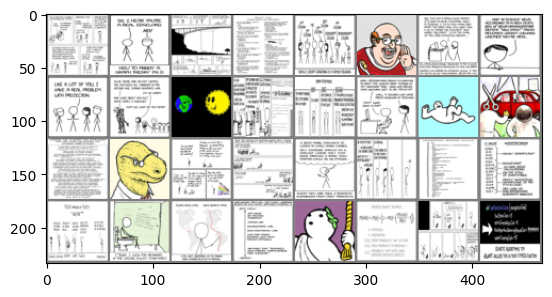

In [121]:
classes = ("xkcd", "pbf")

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
my_iter = iter(my_dataloader)
images, labels = next(my_iter)

# show images
imshow(torchvision.utils.make_grid(images))

In [122]:
print("Defining train class")
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(1).float()
        pred = model(X)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Defining train class


In [123]:
print("Defining test class")
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.unsqueeze(1).float()
            pred = model(X)
            pred_prob = torch.sigmoid(pred)
            pred_binary = (pred_prob > 0.5).float()
            correct += (pred_binary == y).sum().item()
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    correct /= size
    running_test_accuracy.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Defining test class


In [124]:
epochs = 7
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(my_dataloader, model, loss_fn, optimizer)
    test(my_test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.686037  [    0/  907]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.512270 

Epoch 2
-------------------------------
loss: 0.382414  [    0/  907]
Test Error: 
 Accuracy: 70.0%, Avg loss: 0.824123 

Epoch 3
-------------------------------
loss: 0.311125  [    0/  907]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.526417 

Epoch 4
-------------------------------
loss: 0.096297  [    0/  907]
Test Error: 
 Accuracy: 65.5%, Avg loss: 0.887048 

Epoch 5
-------------------------------
loss: 0.236006  [    0/  907]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.592478 

Epoch 6
-------------------------------
loss: 0.334457  [    0/  907]
Test Error: 
 Accuracy: 81.8%, Avg loss: 0.703231 

Epoch 7
-------------------------------
loss: 0.019374  [    0/  907]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.378325 

Done!


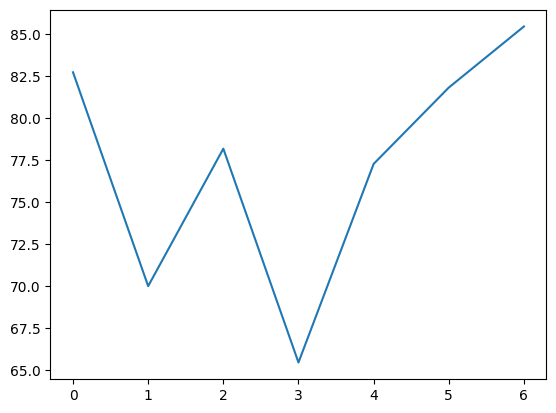

In [130]:
plt.plot(running_test_accuracy)

Read more about [Training your model](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

## Save the model

Done here with an internal state dictionary containing the model parameters

In [126]:
torch.save(model.state_dict(), "model_xkcd.pth")
print("Saved PyTorch Model State to model_xkcd.pth")

Saved PyTorch Model State to model_xkcd.pth


## Load the model

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.

In [127]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_xkcd.pth"))

<All keys matched successfully>

In [128]:
# Define the classes
classes = [
    "xkcd",
    "pbf"
]

# Set the model to evaluation mode
model.eval()

# Get a single sample from the test dataset
x, y = my_test_data[16][0], my_test_data[16][1]

# Add a batch dimension and move to the appropriate device
x = x.unsqueeze(0).to("cpu")  # Shape becomes (1, 3, 28, 28)

# Make predictions
with torch.no_grad():
    pred = model(x)
    predicted = classes[pred[0].argmax(0).item()]  # Get the predicted class
    actual = classes[y]  # Use y directly since it's an int
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "xkcd", Actual: "xkcd"


In [129]:
# Assuming 'model' is your trained model
model_weights = model.state_dict()

# Print the weights
for name, param in model_weights.items():
    print(f"Layer: {name}, Weights: {param.shape}")
    
    
    
# Assuming 'model' is your trained model
model_weights = model.state_dict()

# Print the entire state_dict (optional, can be large)
# print(model_weights)

# Example: Print weights and biases of the first linear layer
# Adjust the key names based on your model architecture
print("Weights of the first linear layer:")
print(model_weights['linear_relu_stack.0.weight'])  # Access weights
print("Biases of the first linear layer:")
print(model_weights['linear_relu_stack.0.bias'])    # Access biases

# Example: Print weights and biases of the second linear layer
print("Weights of the second linear layer:")
print(model_weights['linear_relu_stack.2.weight'])  # Access weights
print("Biases of the second linear layer:")
print(model_weights['linear_relu_stack.2.bias'])    # Access biases

Layer: conv1.weight, Weights: torch.Size([16, 3, 3, 3])
Layer: conv1.bias, Weights: torch.Size([16])
Layer: conv2.weight, Weights: torch.Size([32, 16, 3, 3])
Layer: conv2.bias, Weights: torch.Size([32])
Layer: linear_relu_stack.0.weight, Weights: torch.Size([256, 20000])
Layer: linear_relu_stack.0.bias, Weights: torch.Size([256])
Layer: linear_relu_stack.2.weight, Weights: torch.Size([256, 256])
Layer: linear_relu_stack.2.bias, Weights: torch.Size([256])
Layer: linear_relu_stack.4.weight, Weights: torch.Size([1, 256])
Layer: linear_relu_stack.4.bias, Weights: torch.Size([1])
Weights of the first linear layer:
tensor([[ 9.1878e-04, -6.2491e-03, -3.3548e-03,  ...,  1.3749e-03,
         -2.8677e-03, -5.2199e-03],
        [ 3.3239e-03,  8.4865e-04,  5.9619e-03,  ...,  4.7135e-03,
          1.0916e-03, -2.0025e-03],
        [-7.0607e-03, -5.9533e-03,  6.4712e-04,  ...,  2.0296e-03,
         -5.3233e-06, -7.0695e-03],
        ...,
        [ 3.5178e-03, -3.4317e-03, -3.1899e-03,  ...,  3.1061